In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Perceptron

Idea of artificial neuron (perceptron) was influenced by 1943 paper by McCulloch and Pitts that was trying to understand how real neurons work as a step to creating artificial intelligence. In 1957 Rosenblatt published a paper with a first concept of perceptron. It is a simple binary classification algorithm. Given a decision function $f(z)$, whose input is a linear combination of input values $x$ with corresponding weights $w$ (i.e. $z=w_1x_1+w_2x_2+ \cdots +w_nx_n$). The output of $f$ is either 0 or 1 based on some treshhold value $\theta$:
$$ f(z)=\begin{cases}
    1 & ,z \ge \theta \\
    0 & ,otherwise
    \end{cases}$$

We also add a bias unit $b$ so that $z=w_1x_1+w_2x_2+ \cdots +w_nx_n+b = {\bf w}^T{\bf x} +b$. The "line" $z=\theta$ is called decision boundary and so anything on one side of that line is classified as one class, and anything on the other side is classified as another class. We can train perceptron as follows:

1. Given data and some starting values for weights and bias, we evaluate our function ${\bf w}^T{\bf x} +b$
2. Apply threshold function to classify data and get predictions
3. Compare predictions to real labels and calculate our error (loss)
4. Update parameters and weights.
5. Repeat the process until there is no error or when some stopping critirion is reached

The update part is similar to gradient descent a bit, but our function is not continuous so we can't do it. Instead we update as follows:
$$ w_j=w_j+\Delta w_j =w_j + \eta (y^{(i)}-\hat{y}^{(i)})x^{(i)}_j$$
$$ b=b+\Delta b =b + \eta (y^{(i)}-\hat{y}^{(i)})$$

where $\eta$ is a learning rate.

![Percepdiag.png](attachment:182f4af8-dc53-4384-9e0f-0b90f76e4ce6.png)

### Adaline

In 1960, a paper by Widrow and Hoff improved on a idea of preceptron by creating Adaline (Adaptive Linear Neuron). Main difference is that we no longer compute error using predicting class. Instead we use continuous valuee of activation function. In this case, identity function:

![Adalinediag.png](attachment:3cf00990-64d2-4c7d-89f7-8d12a562f213.png)

For error we are going to apply MSE Loss function and updates are done through gradient descent just like in linear regression. We will run through update loop until we are satisfied, then apply threshold function to get final classification. Most clasification algorithms run through similar loop, just with different activation function and/or threshold function and/or loss function, etc. And neural networks will be contain many such neurons. Let's see how Adaline works on a Iris Data set.

In [ ]:
dataset=datasets.load_iris()

In [ ]:
print(dataset['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [ ]:
X = dataset.data
y = dataset.target

We have three classes in this data set: Iris-Setosa, Iris-Versicolour and Iris-Virginica. Since at this point we can only do binary classification let's remove one class. I will keep the first two classes Setosa and Versicolour. Additionally to simplify our problem I will look only at sepal length and petal lenght.

In [ ]:
X=X[:100, [0,2]]
y=y[:100]

Let's split our data into training and test sets and apply standard scaler.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Let's look at our data graphically

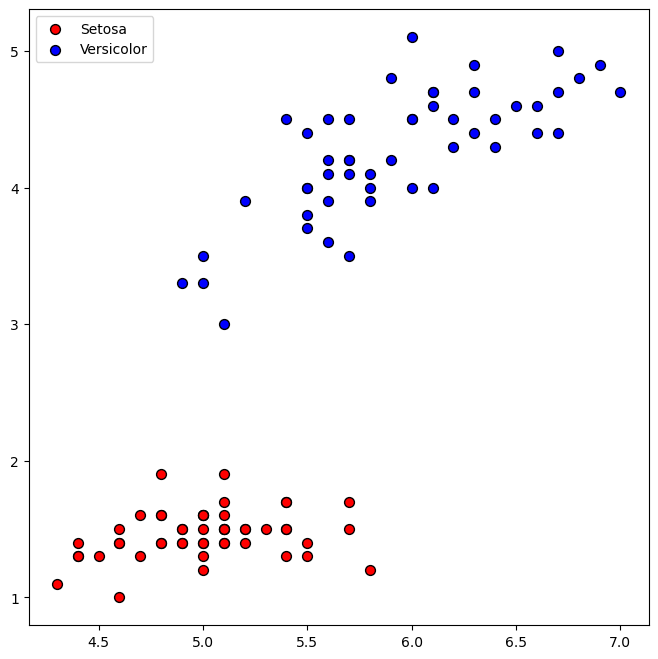

In [ ]:
fig=plt.figure(figsize=(8,8))
plt.scatter(X[:50, 0], X[:50, 1], color='red', s=50, label='Setosa',edgecolors='k')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', s=50, label='Versicolor',edgecolors='k')
plt.legend()
plt.show()

We can clearly see it has nice linear separation. So let's define Adaline class and train it on this data set.

In [ ]:
class Adaline:
    def __init__(self, lr=0.01, n_epoch=150):
        self.lr=lr
        self.n_epoch=n_epoch
        self.weight=None
        self.bias=None

    def func(self, X):
        return np.dot(X, self.weight)+self.bias

    def fit(self, X, y):
        self.weight=np.zeros(X.shape[1])
        self.bias=0.

        for _ in range(self.n_epoch):
            output=self.func(X)
            error = output-y
            dw=2*np.dot(error,X)/X.shape[0]
            db=2*error.mean()

            self.weight=self.weight-self.lr*dw
            self.bias-=self.lr*db

    def predict(self, X):
        return np.where(self.func(X)>=0.5, 1,0)

In [ ]:
ada=Adaline()
ada.fit(X_train, y_train)
confusion_matrix(y_test, ada.predict(X_test))

array([[13,  0],
       [ 0,  7]], dtype=int64)

In [ ]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    markers = ('s', 'x', 'o', '^', 'v')

    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl, 0], X[y==cl, 1],  color=cmap(idx),edgecolors='k',marker=markers[idx],label=cl)



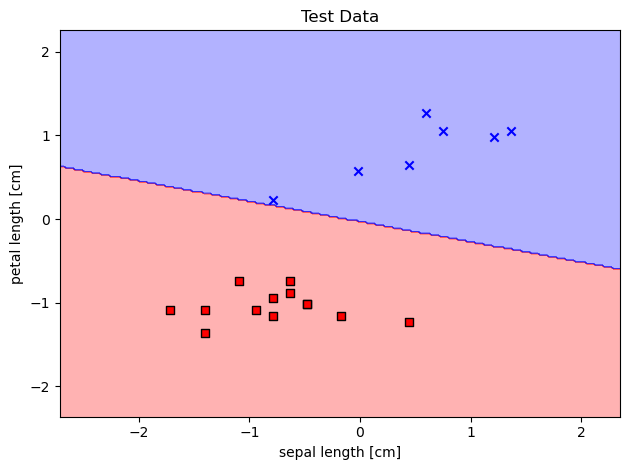

In [ ]:
plot_decision_boundary(X_test, y_test, ada)
plt.title("Test Data")
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.tight_layout()
plt.show()